# Final Project - Inventory Management


Abhijit Mandal

March 7th 2021

## Problem Statement:

* **Context:** A retail firm has many products in their inventory, and very few of them tend to sell (only about 10% sell each year) and many of the products only have a single sale in the course of a year

* **Objective:** The sales and growth team of the retail firm wants to determine which products from their inventory should they retain to sell and the ones to discard 

* **Data:** The data given contains both historical sales data AND active inventory

* **Goal:** We have a to building a binary classifier which gives us a list of product ID which need to retained in the inventory or list of products that need to be removed


In [13]:
# loading important modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
import itertools

%matplotlib inline
matplotlib.style.use('ggplot')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

[]


The dataset contains a detailed set of products in an inventory and the main problem statement here is to determine the products that should continue to sell, and which products to remove from the inventory. The file contains the observations of both historical sales and active inventory data. The end solution here is to create a model that will predict which products to keep and which to remove from the inventory – we’ll perform EDA on this data to understand the data better.

In [14]:
# Reading the dataset
sales_data = pd.read_csv("SalesKaggle3.csv")

We will analyze the dataset and take a closer look at its content. The aim here is to find details like the number of columns and other metadata which will help us to gauge size and other properties such as the range of values in the columns of the dataset.

In [15]:
# Gist of the dataset
sales_data.head()

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,682743.0,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1016014.0,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,340464.0,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,334011.0,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1287938.0,121.95,2010,28,4.00,23.99


In [16]:
#Statistical description of the dataset
sales_data.describe()

,Order,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
count,198917.000000,1.989170e+05,75996.000000,75996.000000,198917.000000,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
mean,106483.543242,8.613626e+05,0.171009,0.322306,3.412202,0.642248,1.117115e+06,90.895243,2006.016414,41.426283,30.982487,46.832053
std,60136.716784,8.699794e+05,0.376519,1.168615,3.864243,0.479340,1.522090e+06,86.736367,9.158331,37.541215,69.066155,128.513236
min,2.000000,5.000100e+04,0.000000,0.000000,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55665.000000,2.172520e+05,0.000000,0.000000,1.000000,0.000000,1.614188e+05,42.000000,2003.000000,21.000000,4.910000,17.950000
50%,108569.000000,6.122080e+05,0.000000,0.000000,2.000000,1.000000,5.822240e+05,69.950000,2007.000000,32.000000,16.080000,33.980000
75%,158298.000000,9.047510e+05,0.000000,0.000000,5.000000,1.000000,1.430083e+06,116.000000,2011.000000,50.000000,40.240000,55.490000
max,208027.000000,3.960788e+06,1.000000,73.000000,99.000000,1.000000,1.738445e+07,12671.480000,2018.000000,2542.000000,14140.210000,19138.790000


In [17]:
# Includes categorical variable 
sales_data.describe(include='all')

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
count,198917.000000,198917,1.989170e+05,75996.000000,75996.000000,198917,198917.000000,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
unique,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Active,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,122921,NaN,NaN,NaN,100946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,106483.543242,NaN,8.613626e+05,0.171009,0.322306,NaN,3.412202,0.642248,1.117115e+06,90.895243,2006.016414,41.426283,30.982487,46.832053
std,60136.716784,NaN,8.699794e+05,0.376519,1.168615,NaN,3.864243,0.479340,1.522090e+06,86.736367,9.158331,37.541215,69.066155,128.513236
min,2.000000,NaN,5.000100e+04,0.000000,0.000000,NaN,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55665.000000,NaN,2.172520e+05,0.000000,0.000000,NaN,1.000000,0.000000,1.614188e+05,42.000000,2003.000000,21.000000,4.910000,17.950000
50%,108569.000000,NaN,6.122080e+05,0.000000,0.000000,NaN,2.000000,1.000000,5.822240e+05,69.950000,2007.000000,32.000000,16.080000,33.980000
75%,158298.000000,NaN,9.047510e+05,0.000000,0.000000,NaN,5.000000,1.000000,1.430083e+06,116.000000,2011.000000,50.000000,40.240000,55.490000


In [18]:
# Basic questions about the dataset

# 1. Number of enteries 
print(sales_data.shape)
# We have 198917 rows and 14 columns 

# 2. Total number of products & unique values of the columns 
print("*****************")
print(sales_data.nunique())

# 3. Count of the historical and active state 
print("*****************")
print(sales_data[sales_data['File_Type'] == 'Historical']['SKU_number'].count())
print(sales_data[sales_data['File_Type'] == 'Active']['SKU_number'].count())

# 3.1 Split the dataset into two parts based on the file_type 
sales_data_hist = sales_data[sales_data['File_Type'] == 'Historical']
sales_data_act = sales_data[sales_data['File_Type'] == 'Active']


(198917, 14)
*****************
Order               198917
File_Type                2
SKU_number          133360
SoldFlag                 2
SoldCount               37
MarketingType            2
ReleaseNumber           71
New_Release_Flag         2
StrengthFactor      197424
PriceReg             11627
ReleaseYear             85
ItemCount              501
LowUserPrice         12102
LowNetPrice          15403
dtype: int64
*****************
75996
122921


### Note: We will be using the historical dataset for the analysis and training the model 

The dataset contains 198,917 rows and 14 columns with 12 numerical and 2 categorical columns. There are 122,921 actively sold products in the dataset, which is where we’ll focus our analysis.

## Univariate distribution plots 

This section shows a frequency histogram for the selected variable along with the density and normal curves for the data

The box plot shows the basic statistics of the data like median, 25th and 75th quantiles and the outliers.

### Categorical Variable

Shows the frequency distribution of the difference factors

The data associated with each attribute includes a long list of values (both numeric and not), and having these values as a long series is not particularly useful yet – they don’t provide any standalone insight. In order to convert the raw data into information we can actually use, we need to summarize and then examine the variable’s distribution.

The univariate distribution plots are graphs where we plot the histograms along with the estimated probability density function over the data. It’s one of the simplest techniques where we consider a single variable and observe its spread and statical properties. The univariate analysis for numerical and categorical attributes are different.

For categorical columns we plot histograms, we use the value_count() and plot.bar() functions to draw a bar plot, which is commonly used for representing categorical data using rectangular bars with value counts of the categorical values. In this case, we have two type of marketing types S and D. The bar plot shows comparisons among these discrete categories, with the x-axis showing the specific categories and the y-axis the measured value.

<AxesSubplot:title={'center':'Freq dist of Marketing Type'}>

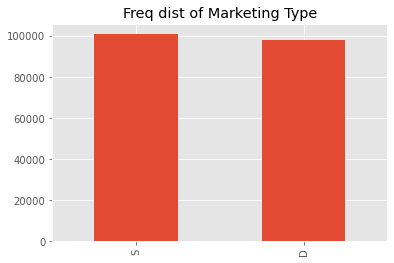

In [19]:
sales_data['MarketingType'].value_counts().plot.bar(title="Freq dist of Marketing Type")

<AxesSubplot:title={'center':'Freq dist of File Type'}>

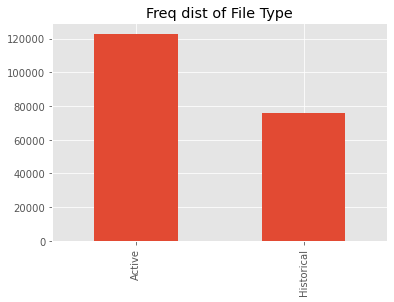

In [20]:
sales_data['File_Type'].value_counts().plot.bar(title="Freq dist of File Type")

<AxesSubplot:title={'center':'Freq dist of New_Release_Flag'}>

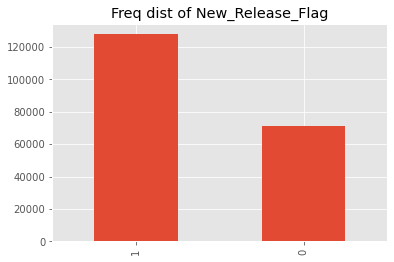

In [21]:
sales_data['New_Release_Flag'].value_counts().plot.bar(title="Freq dist of New_Release_Flag")

<AxesSubplot:title={'center':'Freq dist of MarketingFile Type - active states'}>

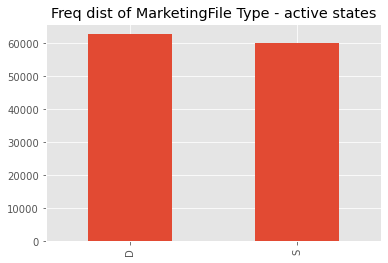

In [22]:
sales_data_act['MarketingType'].value_counts().plot.bar(title="Freq dist of MarketingFile Type - active states")

<AxesSubplot:title={'center':'Freq dist of MarketingFile Type - hist states'}>

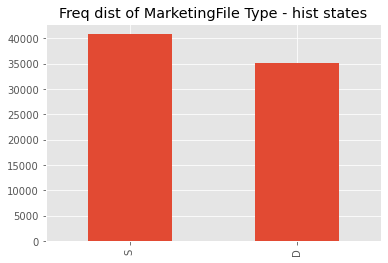

In [23]:
sales_data_hist['MarketingType'].value_counts().plot.bar(title="Freq dist of MarketingFile Type - hist states")

<AxesSubplot:title={'center':'Freq dist of values sold'}>

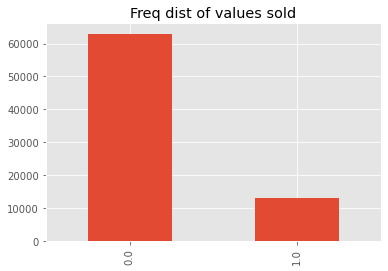

In [24]:
sales_data['SoldFlag'].value_counts().plot.bar(title="Freq dist of values sold")

<AxesSubplot:title={'center':'Strength Factor'}>

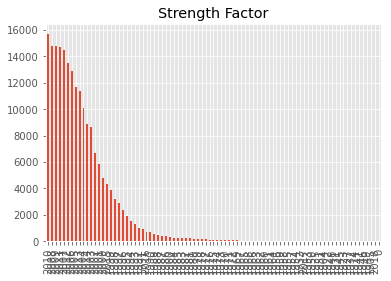

In [40]:
sales_data['ReleaseYear'].value_counts().plot.bar(title="Strength Factor")

### Numeric Variable 

Plots with a kernel density estimate and histogram with bin size determined automatically
By changing the column name in the code above, we can analyze every categorical column.

Below is the code to plot the univariate distribution of the numerical columns which contains the histograms and the estimated PDF. We use displot of the seaborn library to plot this graph:


/Users/abhijitmandal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/abhijitmandal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/abhijitmandal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

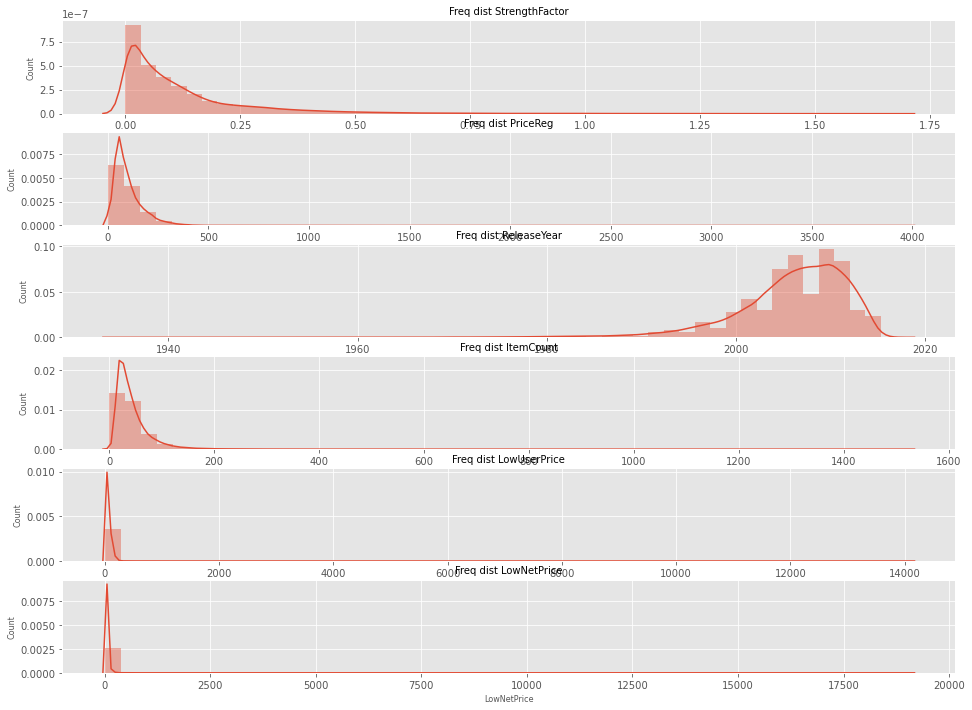

In [25]:
col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):
        
    sns.distplot(sales_data_hist[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)
    
plt.show()

## Outlier detection analysis

An outlier might indicate a mistake in the data (like a typo, or a measuring error, seasonal effects etc), in which case it should be corrected or removed from the data before calculating summary statistics or deriving insights from the data, failing to which will lead to incorrect analysis.

Below is the code to plot the box plot of all the column names mentioned in the list col_names. The box plot allows us to visually analyze the outliers in the dataset.

The key terminology to note here are as follows:

The range of the data provides us with a measure of spread and is equal to a value between the smallest data point (min) and the largest one (Max)
The interquartile range (IQR), which is the range covered by the middle 50% of the data.
IQR = Q3 – Q1, the difference between the third and first quartiles. The first quartile (Q1) is the value such that one quarter (25%) of the data points fall below it, or the median of the bottom half of the data. The third quartile is the value such that three quarters (75%) of the data points fall below it, or the median of the top half of the data.
The IQR can be used to detect outliers using the 1.5(IQR) criteria. Outliers are observations that fall below Q1 – 1.5(IQR) or above Q3 + 1.5(IQR).

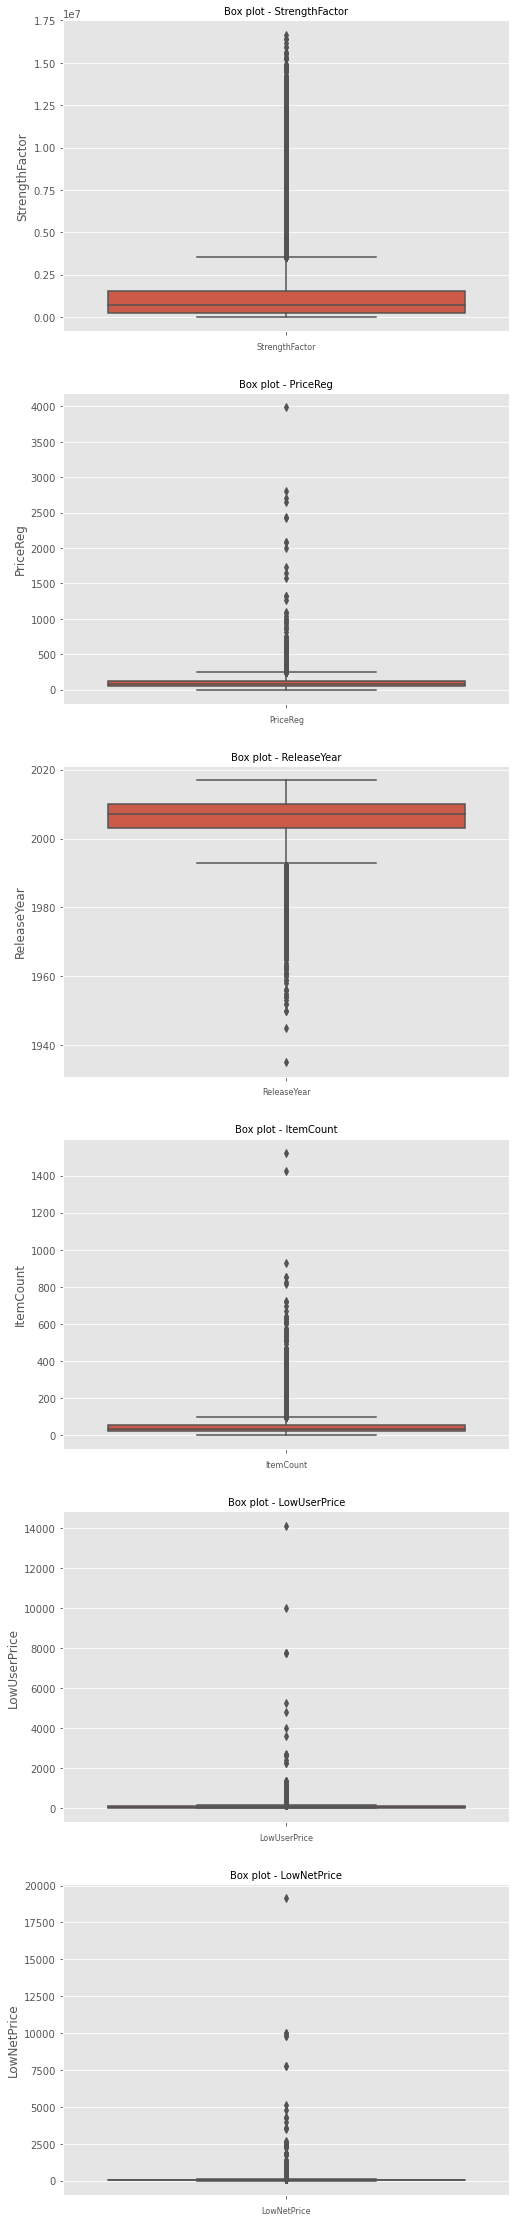

In [26]:
col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
        
    sns.boxplot(y=sales_data_hist[col_val], ax=ax[i])
    ax[i].set_title('Box plot - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

### Bivariate plots 

To plot multiple pairwise bivariate distributions in a dataset
We can see that leaving the ReleaseYear column every other column is skewed to the left which indicates most of the values lie in the lower range values and vice versa in the case of a ReleaseYear attribute.

The bivariate distribution plots help us to study the relationship between two variables by analyzing the scatter plot, and we use the pairplot() function of the seaborn package to plot the bivariate distributions.

We often look out for scatter plots that follow a clear linear pattern with an either increasing or decreasing slope so that we can draw conclusions, but don’t notice these patterns in this particular dataset. That said, there’s always room to derive other insights that might be useful by comparing the nature of the plots between the variables of interest.

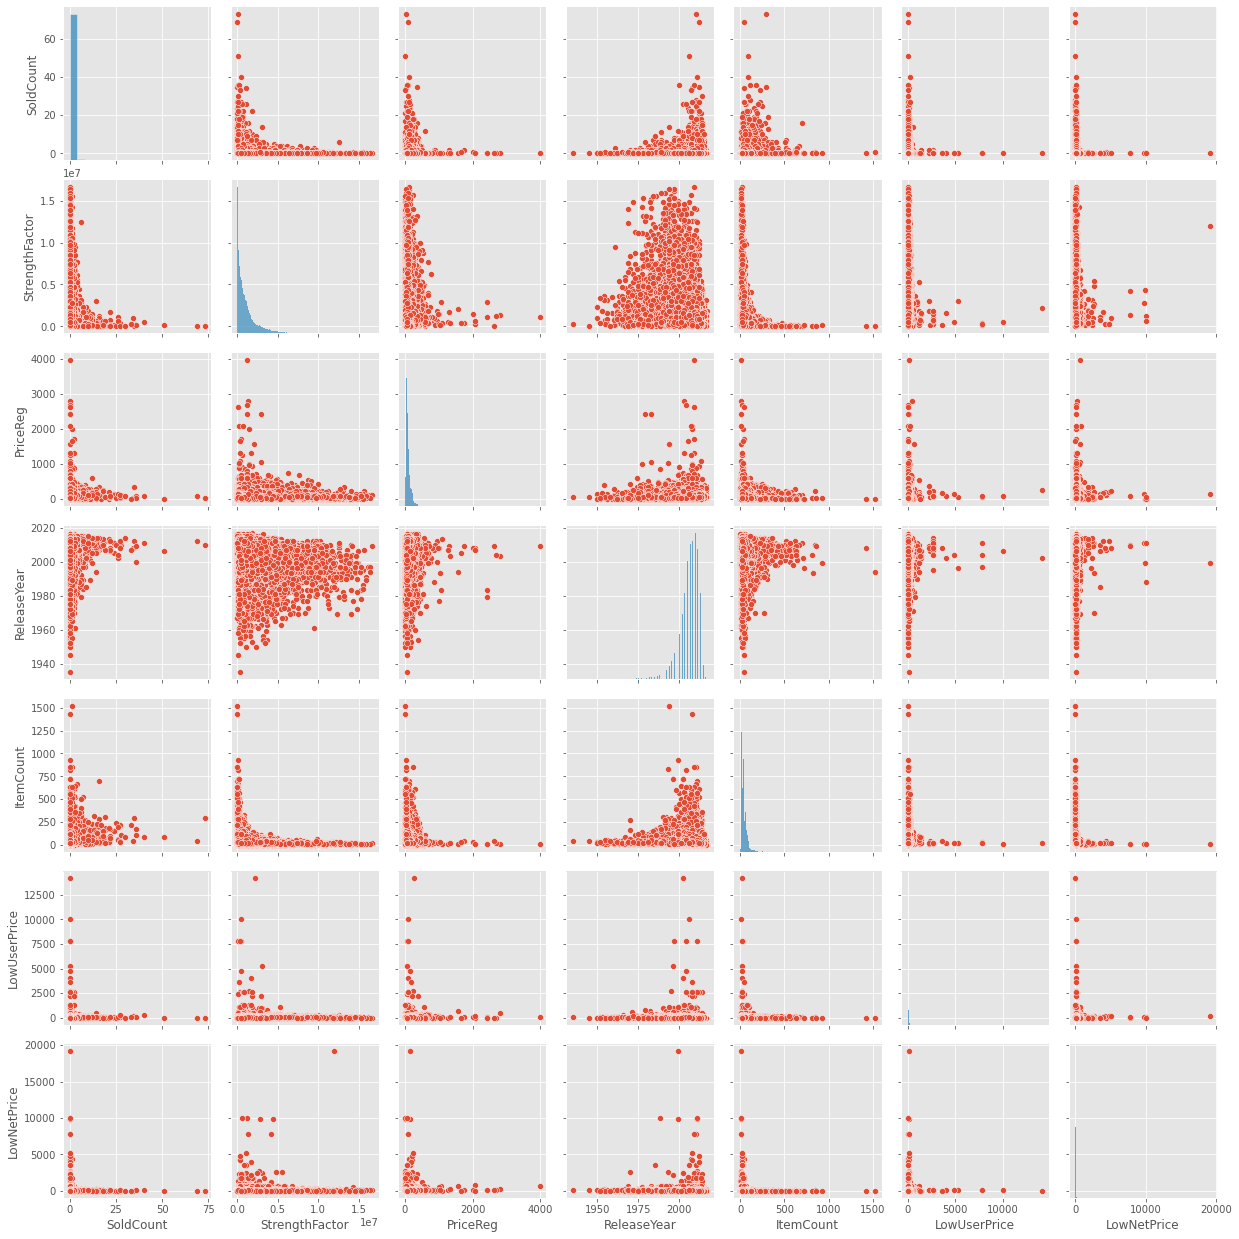

In [27]:
sales_data_hist = sales_data_hist.drop(['Order', 'File_Type','SKU_number','SoldFlag','MarketingType','ReleaseNumber','New_Release_Flag'], axis=1)
sns.pairplot(sales_data_hist)

In [48]:
sales_data['StrengthFactor'].fillna(0, inplace=True)
sales_data['PriceReg'].fillna(0, inplace=True)
sales_data['ReleaseYear'].fillna(0, inplace=True)
sales_data['ItemCount'].fillna(0, inplace=True)
sales_data['LowUserPrice'].fillna(0, inplace=True)
sales_data['LowNetPrice'].fillna(0, inplace=True)

### Correlation plot
A correlation matrix is a table showing the value of the correlation coefficient (Correlation coefficients are used in statistics to measure how strong a relationship is between two variables. ) between sets of variables. Each attribute of the dataset is compared with the other attributes to find out the correlation coefficient. This analysis allows you to see which pairs have the highest correlation, the pairs which are highly correlated represent the same variance of the dataset thus we can further analyze them to understand which attribute among the pairs are most significant for building the model.
Positively correlated variables will have correlation value close to +1 and negatively correlated variables will have correlation value close to -1.

<AxesSubplot:>

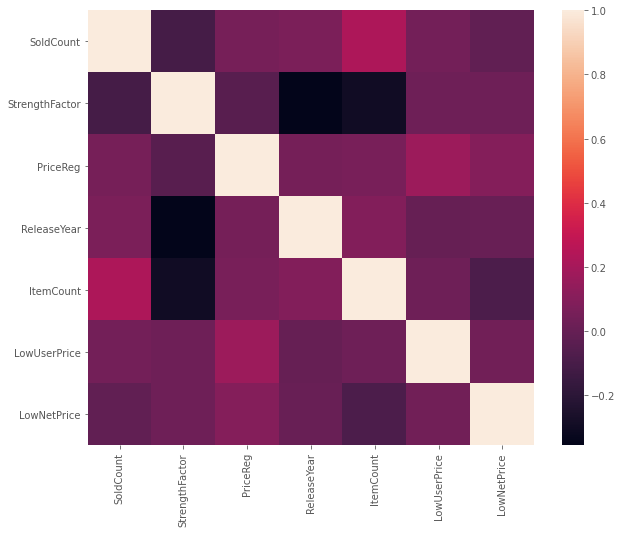

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
corr = sales_data_hist.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

We can see above that the correlation network of all the variables selected, correlation value lies between -1 to +1. Highly correlated variables will have correlation value close to +1 and less correlated variables will have correlation value close to -1.

In this dataset, we don’t see any attributes to be correlated and the diagonal elements of the matrix value are always 1 as we are finding the correlation between the same columns thus the inference here is that all the numerical attributes are important and needs to be considered for building the model.

### Univariate Outlier treatment

Many algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the results and make results less reliable, that's why we have to recognize all the outliers and treat them.

values marked with a dot below in the x-axis of the graph are the ones that are removed from the column based on the set threshold percentile (95 in our case), and is also the default value when it comes to percentile-based outlier removal.

/Users/abhijitmandal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/abhijitmandal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/abhijitmandal/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.war

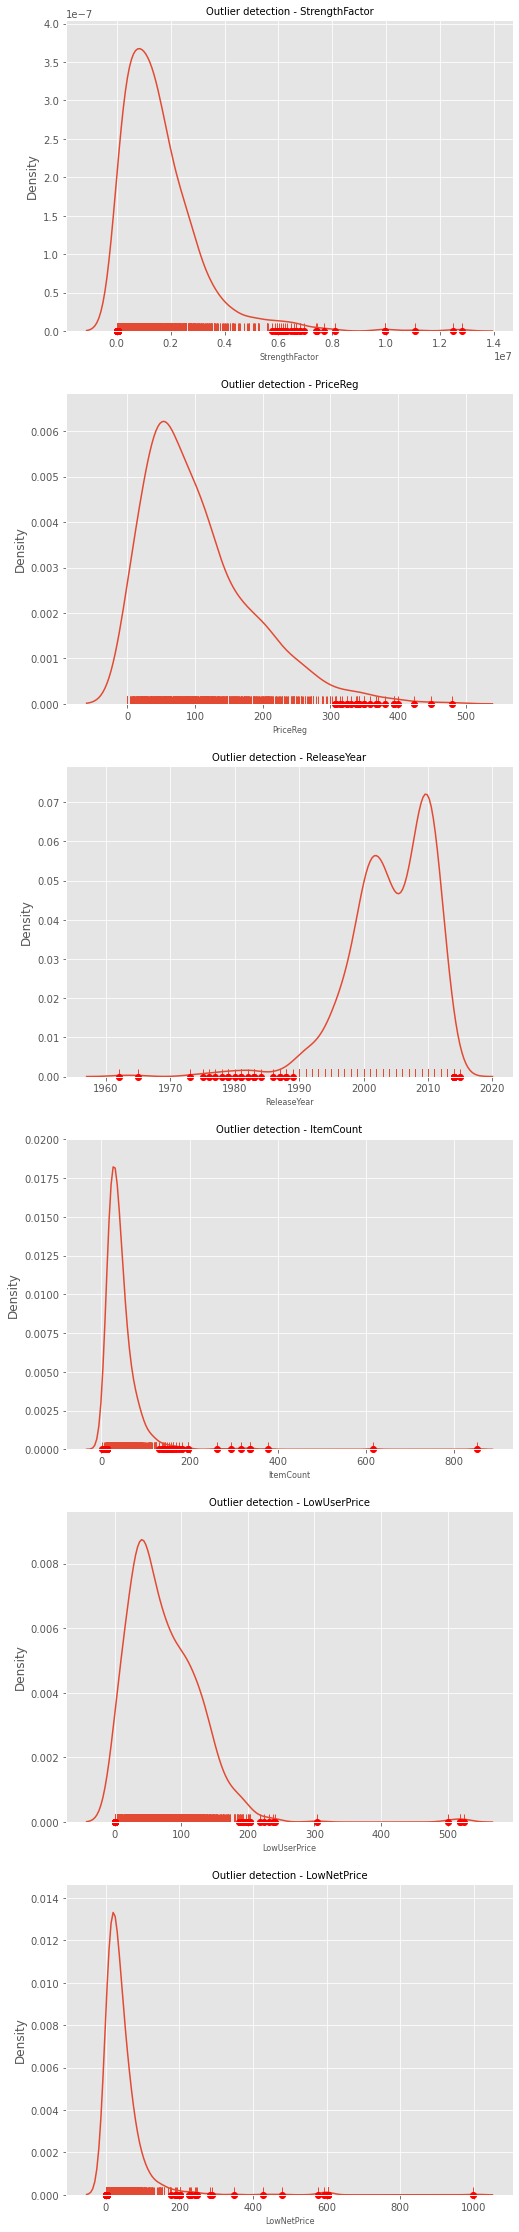

In [29]:
# Percentile based outlier removal 
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

col_names = ['StrengthFactor','PriceReg', 'ReleaseYear', 'ItemCount', 'LowUserPrice', 'LowNetPrice']

fig, ax = plt.subplots(len(col_names), figsize=(8,40))

for i, col_val in enumerate(col_names):
    x = sales_data_hist[col_val][:1000]
    sns.distplot(x, ax=ax[i], rug=True, hist=False)
    outliers = x[percentile_based_outlier(x)]
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    ax[i].set_title('Outlier detection - '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    
plt.show()

## Predictive Modelling

The classification module predicts the SKU which needs to kept in the inventory (Active state) 

In [30]:
# Converting marketing type to categorical variable 
sales_data['MarketingType'] = sales_data['MarketingType'].astype('category')
sales_data['MarketingType'] = sales_data['MarketingType'].cat.codes

# Splitting the historical and active state
sales_data_hist = sales_data[sales_data['File_Type'] == 'Historical']
sales_data_act = sales_data[sales_data['File_Type'] == 'Active']

In [31]:
# Columns to remove 
remove_col_val = ['Order', 'File_Type', 'SKU_number', 'SoldCount', 'ReleaseNumber', 'SoldFlag']

y = sales_data_hist['SoldFlag']

sales_data_hist = sales_data_hist.drop(remove_col_val, axis=1)
sales_data_act = sales_data_act.drop(remove_col_val, axis=1)

# create training and testing vars
training_features, testing_features, training_target, testing_target = train_test_split(sales_data_hist, y, test_size=0.2)
print(training_features.shape, training_target.shape)
print(testing_features.shape, testing_target.shape)

(60796, 8) (60796,)
(15200, 8) (15200,)


In [32]:
print("Class 0 numbers: " , len(training_target[training_target==0.0]))
print("Class 1 numbers: " , len(training_target[training_target==1.0]))

Class 0 numbers:  50365
Class 1 numbers:  10431


In [33]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=12)

In [34]:
# Balancing the classes using SMOTE
sm = SMOTE(random_state=12, sampling_strategy=1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

print("Class 0 numbers: " , len(y_train_res[y_train_res==0.0]))
print("Class 1 numbers: " , len(y_train_res[y_train_res==1.0]))

Class 0 numbers:  45315
Class 1 numbers:  45315


In [35]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(n_estimators=25, random_state=12)

In [36]:
print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(recall_score(y_val, clf_rf.predict(x_val)))

pred = clf_rf.predict(testing_features)

print('\nTest Results')
print(clf_rf.score(testing_features, testing_target))
print(recall_score(testing_target, pred))

print('\nROC AUC score')
print(roc_auc_score(testing_target, pred))

Validation Results
0.750328947368421
0.5446601941747573

Test Results
0.7432894736842105
0.532943469785575

ROC AUC score
0.659467381905055


### Confusion Matrix

Confusion matrix, without normalization
[[9931 2704]
 [1198 1367]]
Normalized confusion matrix
[[0.79 0.21]
 [0.47 0.53]]


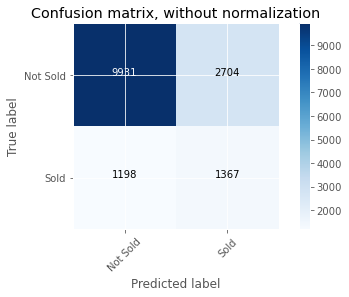

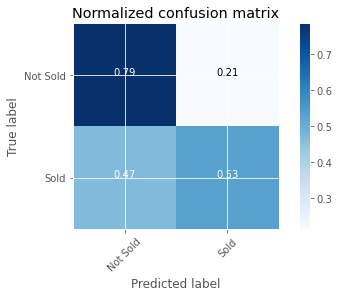

In [37]:
class_names = ['Not Sold', 'Sold']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(testing_target, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### ROC

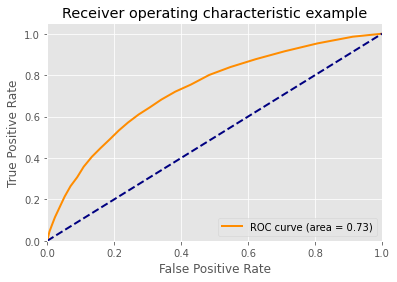

In [50]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
y_score = clf_rf.predict_proba(testing_features)

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testing_target.ravel(), y_score[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['micro'])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
